# Data Visualisation

## 2 - Variation overview

Variants in individuals of recent African origin

In [26]:
# Change working directory

import os
os.chdir(r"C:\Users\User\Desktop\Megan\MSC2\Results\5._Posthoc_analysis\Pipeline_GnomAD_SAHGP_14032023\Genomic_data_analysis\Analysis\Visualisation")

In [27]:
# Import modules and packages

import os
import numpy as np
import pandas as pd
import seaborn as sns
import upsetplot
from matplotlib import pyplot as plt

import sys

sys.path.append(
    r"C:\Users\User\Desktop\Megan\MSC2\Results\5._Posthoc_analysis\Pipeline_GnomAD_SAHGP_14032023\Genomic_data_analysis"
)
import Utils.constants as constants
import Utils.functions as functions

In [28]:
# Set plot figure area and font size
sns.set(rc={"figure.figsize": (10, 8)})

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

### Data import

In [29]:
# Import sample population counts 

grouped_sample_subpopulations = pd.read_csv(
    os.path.join(
        constants.HOME_PATH,
        "Data",
        "Processed",
        "Sample_populations.csv",
    )
).drop(columns="Unnamed: 0")

In [30]:
# Import gene variant counts

recent_african_gene_count_grouped = pd.read_csv(
    os.path.join(
        constants.HOME_PATH,
        "Data",
        "Processed",
        "Gene_variant_counts.csv",
    )
).drop(columns=["Unnamed: 0"])

In [31]:
# Import sub-population allele frequency data

ih_allele_counts = pd.read_csv(
    os.path.join(
        constants.HOME_PATH,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
).drop(columns=["Unnamed: 0"])

In [32]:
# Import variant type and consequence data

variant_type_data = pd.read_csv(
    os.path.join(
        constants.HOME_PATH,
        "Data",
        "Processed",
        "Variant_types_and_consequences.csv",
    ), usecols=["ID", "REF", "ALT", "POS", "GENE", "CONSEQUENCE", "CONSEQUENCE_CLASSIFICATION"]
)

### Number of variants as a function of population group size

In [33]:
# Re-use ih_allele_counts dataframe. Remove rows with variants with alternate allele frequencies of 0. These variants are not present in the subpopulation.
region_specific_allele_counts = ih_allele_counts.dropna(subset="SUB_POP")[~(ih_allele_counts.CORR_IH_AF == 0.0)]

# Drop ASW and ACB regions
region_specific_allele_counts = region_specific_allele_counts[~ ((region_specific_allele_counts.REG == "ACB") | (region_specific_allele_counts.REG == "ASW"))]

region_specific_allele_counts.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_12604\4221086452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  region_specific_allele_counts = ih_allele_counts.dropna(subset="SUB_POP")[~(ih_allele_counts.CORR_IH_AF == 0.0)]


,ID,REF,ALT,IH_REF_CTS,IH_ALT_CTS,POP_ALLELE_COUNT,SUB_POP,REG,VARIANT_TYPE,CORR_IH_REF_CTS,CORR_IH_AF,POS,GENE,UNIQUE_VARIANT_NAME
12,chr11:34438836T-C,T,C,193,1,194,LWK,EA,SNP,193,0.005155,34438836,CAT,34438836_C_T
37,chr11:34438889G-C,G,C,11,1,12,San,SA,SNP,11,0.083333,34438889,CAT,34438889_C_G
143,chr11:34439223G-C,G,C,350,2,352,GWD,WA,SNP,350,0.005682,34439223,CAT,34439223_C_G
179,chr11:34439262C-T,C,T,41,1,42,Yoruba,WA,SNP,41,0.023810,34439262,CAT,34439262_T_C
203,chr11:34439312G-A,G,A,15,1,16,BantuSouthAfrica,SA,SNP,15,0.062500,34439312,CAT,34439312_A_G


In [34]:
# Order subpopulations by sample count. Re-use grouped_sample_subpopulations dataframe.
subpopulation_order = grouped_sample_subpopulations.sort_values(by=["SAMPLE_COUNT", "REG"]).SUB.tolist()
subpopulation_order

# Order subpopulations in region_specific_allele_counts dataframe. 
collated_af_ordered = region_specific_allele_counts.copy()
collated_af_ordered.sort_values(by="SUB_POP", key=lambda column: column.map(lambda e: subpopulation_order.index(e)), inplace=True)

# Remove duplicated variants to avoid counting the same variant twice.
collated_af_unique = collated_af_ordered.drop_duplicates(subset=["UNIQUE_VARIANT_NAME"])

In [35]:
# Group by sub-population and count cumulative number of variants
collated_af_subpop = collated_af_unique.groupby(["SUB_POP"]).size().reset_index().rename(columns={0:"VARIANT_COUNT"})
collated_af_subpop.sort_values(by="SUB_POP", key=lambda column: column.map(lambda e: subpopulation_order.index(e)), inplace=True)
collated_af_subpop["CUMULATIVE_TOTAL_VARIANTS"] = collated_af_subpop["VARIANT_COUNT"].cumsum()

# Add sample count information to dataframe and count cumulative number of samples
collated_af_subpop = collated_af_subpop.merge(grouped_sample_subpopulations, left_on="SUB_POP", right_on="SUB").drop(columns=["SUB"]).set_index("SUB_POP")
collated_af_subpop["CUMULATIVE_SAMPLES"] = collated_af_subpop.sort_values(by=["VARIANT_COUNT", "REG"], ascending=True)["SAMPLE_COUNT"].cumsum()
collated_af_subpop.head(5)

,VARIANT_COUNT,CUMULATIVE_TOTAL_VARIANTS,SAMPLE_COUNT,REG,CUMULATIVE_SAMPLES
SUB_POP,,,,,
San,2267,2267,6,SA,828
BantuSouthAfrica,949,3216,8,SA,725
COL,422,3638,8,SA,59
SOT,306,3944,8,SA,16
XHO,192,4136,8,SA,8


In [36]:
# Find the number of SNPs per sub-population re-using the collated_af_unique dataframe

# Subset data by SNPs
collated_af_snp = collated_af_unique[collated_af_unique.VARIANT_TYPE.str.contains("SNP")].reset_index(drop=True)

# Group by sub-population and count cumulative number of variants
collated_af_subpop_snp = collated_af_snp.groupby("SUB_POP").size().reset_index().rename(columns={0:"SNP_COUNT"})
collated_af_subpop_snp.sort_values(by="SUB_POP", key=lambda column: column.map(lambda e: subpopulation_order.index(e)), inplace=True)
collated_af_subpop_snp["CUMULATIVE_SNPS"] = collated_af_subpop_snp["SNP_COUNT"].cumsum()

In [37]:
# Find the number of INDELs per sub-population re-using the collated_af_unique dataframe

# Subset data by INDELs
collated_af_indel = collated_af_unique[collated_af_unique.VARIANT_TYPE.str.contains("INDEL")].reset_index(drop=True)

# Group by sub-population and count cumulative number of variants
collated_af_subpop_indel = collated_af_indel.groupby("SUB_POP").size().reset_index().rename(columns={0:"INDEL_COUNT"})
collated_af_subpop_indel.sort_values(by="SUB_POP", key=lambda column: column.map(lambda e: subpopulation_order.index(e)), inplace=True)
collated_af_subpop_indel["CUMULATIVE_INDELS"] = collated_af_subpop_indel["INDEL_COUNT"].cumsum()

In [38]:
# Combine data

collated_af_subpop_all = collated_af_subpop_snp.merge(collated_af_subpop, on=["SUB_POP"])
collated_af_subpop_all = collated_af_subpop_all.merge(collated_af_subpop_indel, on=["SUB_POP"])
collated_af_subpop_all = collated_af_subpop_all.drop(columns=["SNP_COUNT", "INDEL_COUNT", "VARIANT_COUNT", "SAMPLE_COUNT"]).sort_values(by=["CUMULATIVE_TOTAL_VARIANTS", "REG"], ascending= True)

# Rename subpopulations prior to plotting
collated_af_subpop_all = collated_af_subpop_all.replace({"SUB_POP": constants.SUBPOP_RENAME})

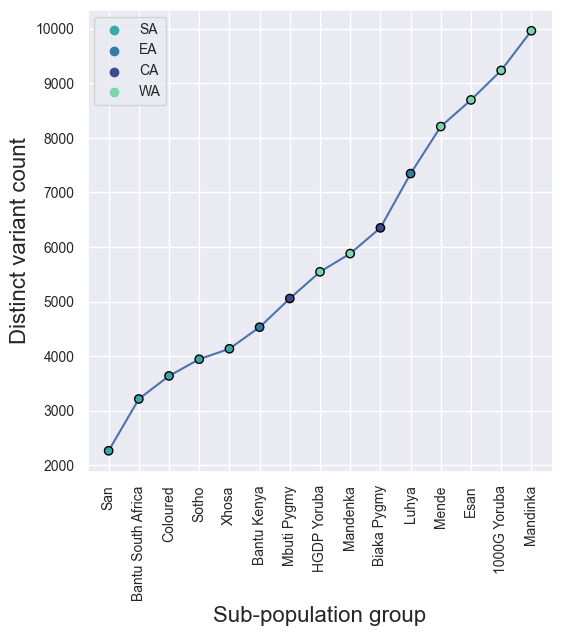

In [39]:
# Plot number of variants as a function of sample size
fig, ax = plt.subplots(figsize=(6, 6))

color_dict = dict({'SA':'#38AAAC',
                  'EA':'#357BA3',
                  'CA': '#40498E',
                  'WA': '#79D6AE'})

cum_variant_lineplot = sns.scatterplot(
    data=collated_af_subpop_all,
    x="SUB_POP",
    y="CUMULATIVE_TOTAL_VARIANTS",
    marker="o",
    hue="REG",
    palette=color_dict,
    edgecolor='black',
    linewidth = 1,
    zorder=100
)
cum_variant_lineplot = sns.lineplot(
    data=collated_af_subpop_all,
    x="SUB_POP",
    y="CUMULATIVE_TOTAL_VARIANTS",
    marker=None,
    zorder=1
)


cum_variant_lineplot.set(xlabel="Sub-population group", ylabel="Distinct variant count")

# Plot novel variants as a function of sample size
plt.xticks(rotation=90)
plt.savefig("..\..\Results\Figures\Variant_discovery_curve.png", dpi=1200, bbox_inches="tight")
plt.show()


### Allele frequency vs variant count for individuals of recent African origin

In [106]:
# Re-use ih_recent_afr dataframe. Divide allele frequencies into bins.

ih_recent_afr= ih_allele_counts[(ih_allele_counts.REG == "Recent African") & ~(ih_allele_counts.IH_ALT_CTS == 0)]
ih_recent_afr["QUANTILE"] = pd.cut(ih_recent_afr["CORR_IH_AF"], [0.0, 0.001, 0.005, 0.05, 0.5, 1.0], labels=["very rare: < 0.001", "rare: 0.001-0.005", "low frequency: 0.005-0.05", "common: 0.05-0.5", "very common: > 0.5"])
ih_recent_afr.head()

C:\Users\User\AppData\Local\Temp\ipykernel_12604\1928798104.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ih_recent_afr["QUANTILE"] = pd.cut(ih_recent_afr["CORR_IH_AF"], [0.0, 0.001, 0.005, 0.05, 0.5, 1.0], labels=["very rare: < 0.001", "rare: 0.001-0.005", "low frequency: 0.005-0.05", "common: 0.05-0.5", "very common: > 0.5"])


,ID,REF,ALT,IH_REF_CTS,IH_ALT_CTS,POP_ALLELE_COUNT,SUB_POP,REG,VARIANT_TYPE,CORR_IH_REF_CTS,CORR_IH_AF,POS,GENE,UNIQUE_VARIANT_NAME,QUANTILE
4,chr11:34438836T-C,T,C,1607,1,1656,NaN,Recent African,SNP,1655,0.000604,34438836,CAT,34438836_C_T,very rare: < 0.001
31,chr11:34438889G-C,G,C,1607,1,1656,NaN,Recent African,SNP,1655,0.000604,34438889,CAT,34438889_C_G,very rare: < 0.001
135,chr11:34439223G-C,G,C,1606,2,1656,NaN,Recent African,SNP,1654,0.001208,34439223,CAT,34439223_C_G,rare: 0.001-0.005
186,chr11:34439262C-T,C,T,1607,1,1656,NaN,Recent African,SNP,1655,0.000604,34439262,CAT,34439262_T_C,very rare: < 0.001
191,chr11:34439312G-A,G,A,1607,1,1656,NaN,Recent African,SNP,1655,0.000604,34439312,CAT,34439312_A_G,very rare: < 0.001


In [101]:
# Group by quantile and gene

ih_recent_afr_binned_grouped = functions.group_and_count(data=ih_recent_afr[["QUANTILE", "GENE", "ID"]], group_columns=["QUANTILE", "GENE"]).reset_index().rename(columns={"ID": "COUNT"})
ih_recent_afr_binned_grouped.head(5)


,QUANTILE,GENE,COUNT
0,very rare: < 0.001,AGT,345
1,very rare: < 0.001,AP4B1,57
2,very rare: < 0.001,CARD8,543
3,very rare: < 0.001,CAT,200
4,very rare: < 0.001,COL4A1,1083


In [96]:
# Pivot data before plotting

ih_recent_afr_binned_pivot = ih_recent_afr_binned_grouped.pivot(index="GENE", columns="QUANTILE", values="COUNT")
ih_recent_afr_binned_pivot.head(5)

# Temp fix - replace values of 0 with 0.001 - to allow correct labelling of barplot values

ih_recent_afr_binned_pivot = ih_recent_afr_binned_pivot.replace(0, 0.001)

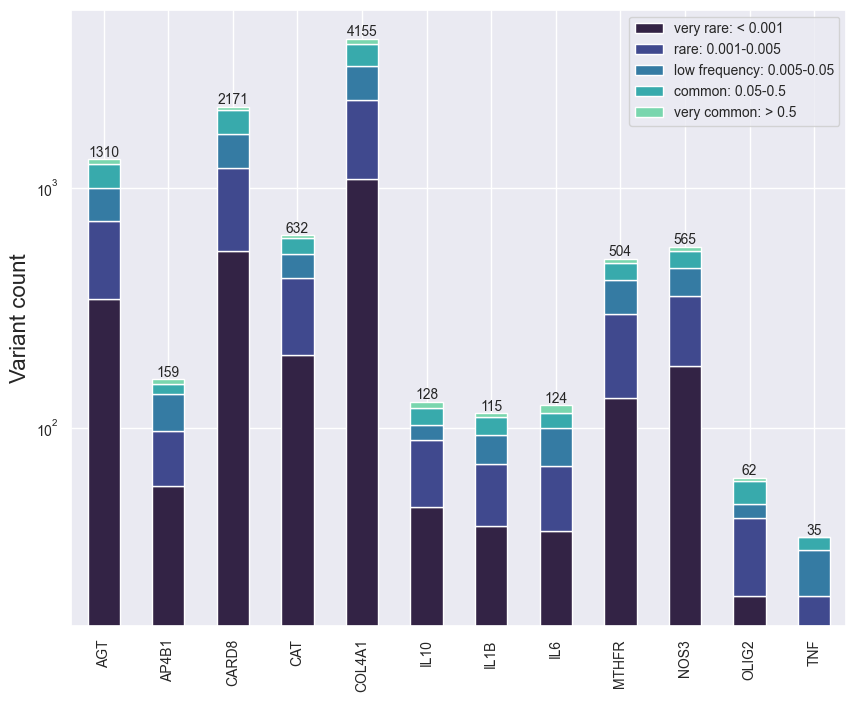

In [99]:
# Generate barplot of quantile counts per gene

af_barplot = functions.create_plot(
    plot_type="stacked_barplot",
    data=ih_recent_afr_binned_pivot,
    palette=sns.set_palette("mako", 5),
    xlabel=None,
    ylabel="Variant count",
    plot_title=None
)

af_barplot.bar_label(af_barplot.containers[4], fmt='%.0f')
plt.yscale("log")
plt.savefig("..\..\Results\Figures\Variant_frequencies.png", dpi=1200)
plt.show()


### How many of the rare or very rare variants were potentially novel?

In [125]:
# Re-use ih_recent_afr dataframe. Subset by variants that are rare or very rare.

total_rare = ih_recent_afr[ih_recent_afr.CORR_IH_AF < 0.005]["UNIQUE_VARIANT_NAME"].count()
novel_rare = ih_recent_afr[(ih_recent_afr.CORR_IH_AF < 0.005) & ~ (ih_recent_afr.ID.str.contains("rs"))]["UNIQUE_VARIANT_NAME"].count()
non_novel_rare = total_rare-novel_rare
novel_percentage = (novel_rare/total_rare) * 100

novel_percentage

40.28361344537815

### Consequences for all variant types

In [ ]:
# Re-use ih_recent_afr dataframe. Add variant type and consequence information from variant_type_data dataframe. 

ih_recent_afr_conseq = ih_recent_afr.merge(variant_type_data, how="left", on=["ID", "REF", "ALT", "GENE", "POS"])

ih_recent_afr_conseq.head(5)

,ID,REF,ALT,IH_REF_CTS,IH_ALT_CTS,POP_ALLELE_COUNT,SUB_POP,REG,VARIANT_TYPE,CORR_IH_REF_CTS,CORR_IH_AF,POS,GENE,UNIQUE_VARIANT_NAME,QUANTILE,CONSEQUENCE,CONSEQUENCE_CLASSIFICATION
0,chr11:34438836T-C,T,C,1607,1,1656,NaN,Recent African,SNP,1655,0.000604,34438836,CAT,34438836_C_T,very rare: < 0.001,upstream_gene_variant,upstream
1,chr11:34438889G-C,G,C,1607,1,1656,NaN,Recent African,SNP,1655,0.000604,34438889,CAT,34438889_C_G,very rare: < 0.001,upstream_gene_variant,upstream
2,chr11:34439223G-C,G,C,1606,2,1656,NaN,Recent African,SNP,1654,0.001208,34439223,CAT,34439223_C_G,rare: 0.001-0.005,intron_variant,intronic
3,chr11:34439262C-T,C,T,1607,1,1656,NaN,Recent African,SNP,1655,0.000604,34439262,CAT,34439262_T_C,very rare: < 0.001,intron_variant,intronic
4,chr11:34439312G-A,G,A,1607,1,1656,NaN,Recent African,SNP,1655,0.000604,34439312,CAT,34439312_A_G,very rare: < 0.001,intron_variant,intronic


In [ ]:
# Count variants per gene and consequence
recent_afr_conseq_grouped = functions.group_and_count(
    ih_recent_afr_conseq, ["GENE", "CONSEQUENCE_CLASSIFICATION"]
).reset_index().rename(columns={"ID": "COUNT"})

recent_afr_conseq_pivot = recent_afr_conseq_grouped.pivot(
    index="GENE", columns="CONSEQUENCE_CLASSIFICATION", values="COUNT"
).replace(np.NAN, 0)

# Add total variant count information from recent_african_gene_count_grouped dataframe. Use the total count information to calculate the number of variants without consequence classifications.
recent_afr_conseq_tc = recent_afr_conseq_pivot.merge(recent_african_gene_count_grouped, on="GENE").set_index("GENE")

# Calculate variants with unclassified consequences
recent_afr_conseq_tc["unclassified"] = recent_afr_conseq_tc.COUNT - recent_afr_conseq_tc.iloc[:, :-1].sum(axis=1)

# Remove count column
recent_afr_conseq_tc = recent_afr_conseq_tc.drop(columns="COUNT")

recent_afr_conseq_tc.head(5)

,3-prime UTR,5-prime UTR,downstream,exonic,intronic,splice donor,splice region,upstream,unclassified
GENE,,,,,,,,,
AGT,10.0,1.0,113.0,32.0,234.0,0.0,3.0,126.0,791.0
AP4B1,9.0,2.0,1.0,29.0,100.0,0.0,0.0,17.0,1.0
CARD8,85.0,6.0,184.0,38.0,1092.0,1.0,3.0,12.0,750.0
CAT,17.0,1.0,4.0,15.0,581.0,3.0,1.0,4.0,6.0
COL4A1,16.0,2.0,2.0,55.0,4034.0,4.0,12.0,2.0,28.0


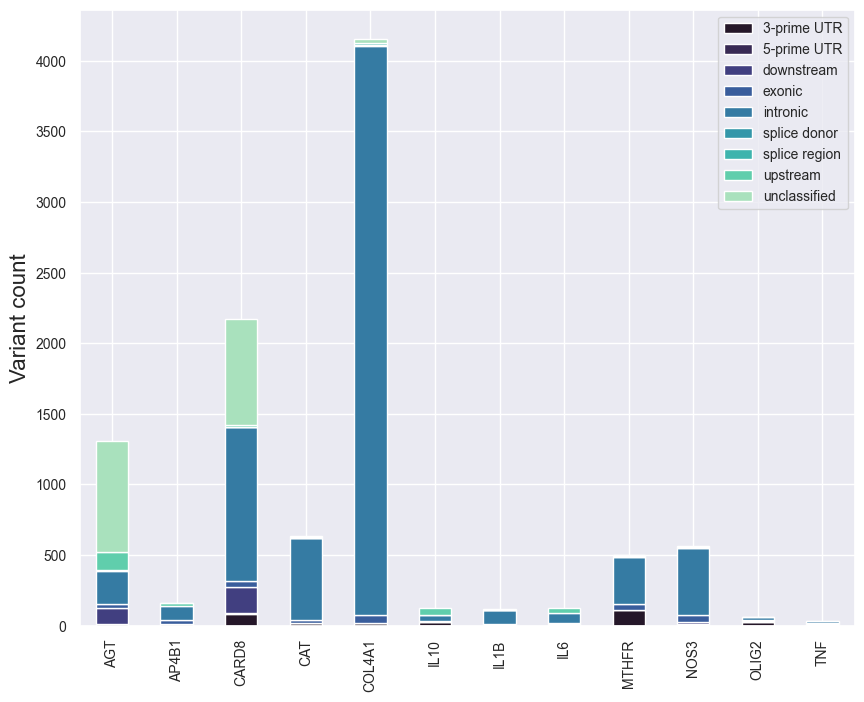

In [ ]:
# Create barplot

# Define a custom colour palette for plot
custom_palette = sns.color_palette("mako", 9)

# Construct barplot
consequence_plot = functions.create_plot(
    plot_type="stacked_barplot",
    palette=custom_palette,
    data=recent_afr_conseq_tc,
    xlabel=None,
    ylabel="Variant count",
    plot_title=None,
)
plt.savefig("..\..\Results\Figures\Variant_types.png", dpi=1200)
plt.show()

### Consequences for exonic variants

In [ ]:
# Subset consequence dataframe by exonic variant types
ih_recent_afr_exonic = ih_recent_afr_conseq[ih_recent_afr_conseq.CONSEQUENCE_CLASSIFICATION == "exonic"]

# Count unique variants for each gene and sub-population
ih_recent_afr_exonic_grouped = functions.group_and_count(
    ih_recent_afr_exonic, ["GENE", "CONSEQUENCE"]
)

ih_recent_afr_exonic_grouped = (
    ih_recent_afr_exonic_grouped["ID"].reset_index().rename(columns={"ID": "COUNT"})
)

ih_recent_afr_exonic_pivot = ih_recent_afr_exonic_grouped.pivot(
    index="GENE", columns="CONSEQUENCE", values="COUNT"
)

ih_recent_afr_exonic_pivot.head(5)

CONSEQUENCE,frameshift_variant,inframe_deletion,missense_variant,start_lost,stop_gained,synonymous_variant
GENE,,,,,,
AGT,NaN,NaN,19.0,NaN,NaN,13.0
AP4B1,NaN,NaN,18.0,NaN,1.0,10.0
CARD8,1.0,NaN,22.0,1.0,NaN,14.0
CAT,NaN,NaN,9.0,NaN,NaN,6.0
COL4A1,NaN,NaN,15.0,NaN,NaN,40.0


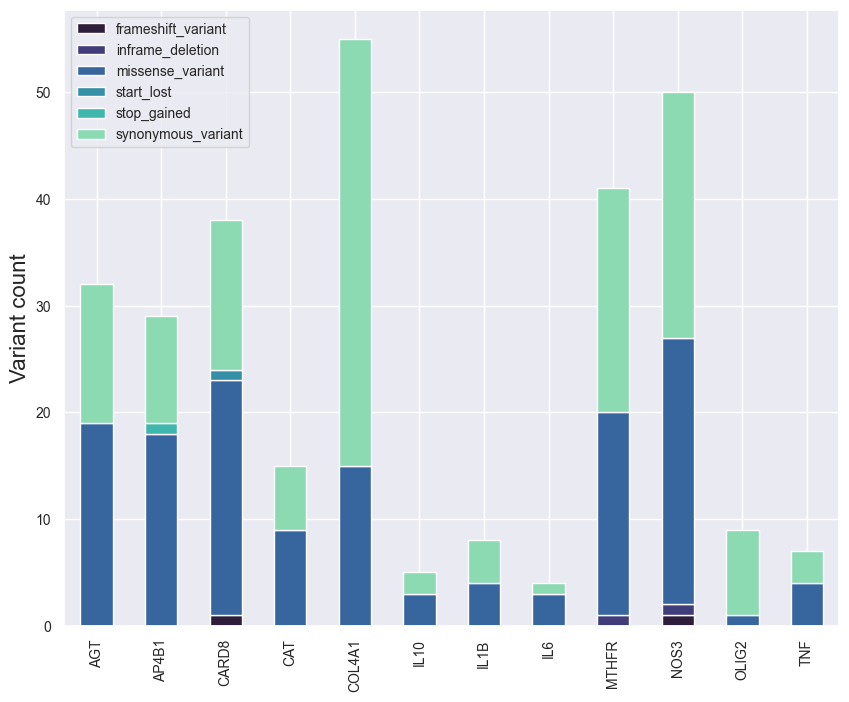

In [ ]:
# Create barplot

# Define a custom colour palette for plot
custom_palette = sns.color_palette("mako", 6)

# Construct barplot
consequence_plot = functions.create_plot(
    plot_type="stacked_barplot",
    palette=custom_palette,
    data=ih_recent_afr_exonic_pivot,
    xlabel=None,
    ylabel="Variant count",
    plot_title=None,
)
plt.savefig("..\..\Results\Figures\Variant_types_exonic.png", dpi=1200)
plt.show()